## Load and normalizing the CIFAR10 Training and Test datasets using TorchVision

In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import os
from skimage import io, transform
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
label_map = {
    'dog': 0,
    'bird': 1, 
    'airplane': 2,
    'horse': 3,
    'frog': 4,
    'automobile': 5,
    'cat': 6,
    'deer': 7,
    'truck': 8, 
    'ship': 9
}

def get_category(i):
    for k, v in label_map.items():
        if v == i:
            return k

In [3]:
class CifarDataset(torch.utils.data.Dataset):
  
  def __init__(self, root_dir, transform=None):
    '''
    Args:
      root_dir (string): dir with all the images
      transform (callable, optional): Optional transform to be
        applied on a sample
    '''
    self.root_dir = root_dir
    self.files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    img_name = self.files[idx]
    image = io.imread(os.path.join(self.root_dir, img_name))

    category = img_name[:-4].split('_')[-1]
    label = label_map[category]

    if self.transform:
      image = self.transform(image)

    return image, label

In [4]:
class Rescale(object):

  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, image):
    h, w = image.shape[:2]
    if isinstance(self.output_size, int):
      if h > w:
        new_h, new_w = self.output_size * h / w, self.output_size
      else:
        new_h, new_w = self.output_size, self.output_size * w / h
    else:
      new_h, new_w = self.output_size

    img = transform.resize(image, (int(new_h), int(new_w)))
    return img

In [5]:
trainset = CifarDataset(root_dir='./data/cifar/train', transform=torchvision.transforms.Compose([Rescale(32)]))
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = CifarDataset(root_dir='./data/cifar/test', transform=torchvision.transforms.Compose([Rescale(32)]))
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


## Visualizing the some random images/labels from the CIFAR10 dataset

automobile


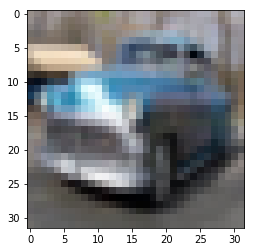

In [6]:
# get a random training image
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.imshow(images[0].numpy())
print(get_category(labels[0]))

## Setup GPU if detected

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


## Define CNN

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Define a Loss Function and Optimizer


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the CNN

In [20]:
for epoch in range(10):  # loop over the dataset multiple times (probably 10 epochs...)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # enforce shape & cast to floats
        inputs = inputs.view([4, 3, 32, 32]).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.cuda())
        loss = criterion(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.523
[1,  4000] loss: 1.539
[1,  6000] loss: 1.562
[1,  8000] loss: 1.543
[1, 10000] loss: 1.526
[1, 12000] loss: 1.536
[2,  2000] loss: 1.507
[2,  4000] loss: 1.507
[2,  6000] loss: 1.513
[2,  8000] loss: 1.494
[2, 10000] loss: 1.500
[2, 12000] loss: 1.494
[3,  2000] loss: 1.468
[3,  4000] loss: 1.462
[3,  6000] loss: 1.461
[3,  8000] loss: 1.478
[3, 10000] loss: 1.464
[3, 12000] loss: 1.490
[4,  2000] loss: 1.423
[4,  4000] loss: 1.436
[4,  6000] loss: 1.433
[4,  8000] loss: 1.459
[4, 10000] loss: 1.464
[4, 12000] loss: 1.459
[5,  2000] loss: 1.384
[5,  4000] loss: 1.413
[5,  6000] loss: 1.404
[5,  8000] loss: 1.444
[5, 10000] loss: 1.426
[5, 12000] loss: 1.452
[6,  2000] loss: 1.372
[6,  4000] loss: 1.377
[6,  6000] loss: 1.394
[6,  8000] loss: 1.406
[6, 10000] loss: 1.414
[6, 12000] loss: 1.429
[7,  2000] loss: 1.359
[7,  4000] loss: 1.369
[7,  6000] loss: 1.358
[7,  8000] loss: 1.390
[7, 10000] loss: 1.399
[7, 12000] loss: 1.389
[8,  2000] loss: 1.343
[8,  4000] 

## Test the network on the test data

Load images from the testloader and also see their labels to know the 'truth'

dog


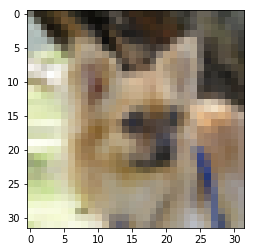

In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

plt.imshow(images[1].numpy())
print(get_category(labels[1]))

Predict the classes of the images to contrast the 'ground truth' results

In [23]:
images = images.view([4, 3, 32, 32]).float()

outputs = net(images.cuda())

_, predicted = torch.max(outputs, 1)

print(get_category(predicted[1]))

dog


Let us look at how the network performs on the whole dataset.

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view([4, 3, 32, 32]).float()
        outputs = net(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 44 %


What are the classes that performed well, and the classes that did not perform well?

In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view([4, 3, 32, 32]).float()
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(images.cuda())
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %10s : %3d %%' % (
        get_category(i), 100 * class_correct[i] / class_total[i]))

Accuracy of        dog :  35 %
Accuracy of       bird :  41 %
Accuracy of   airplane :  51 %
Accuracy of      horse :  44 %
Accuracy of       frog :  52 %
Accuracy of automobile :  71 %
Accuracy of        cat :  32 %
Accuracy of       deer :  26 %
Accuracy of      truck :  33 %
Accuracy of       ship :  55 %


## Save model

In [27]:
torch.save(net.state_dict(), "model0")